In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git


In [1]:
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
# pip install tensorflow_datasets

In [3]:
import tensorflow_datasets as tfds
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import platform
from model import atp_graph, atp_pipeline, model_init

/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-05-31 22:57:45.246019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-31 22:57:45.246167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')

  plt.show()

2023-05-31 22:57:52.675983: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


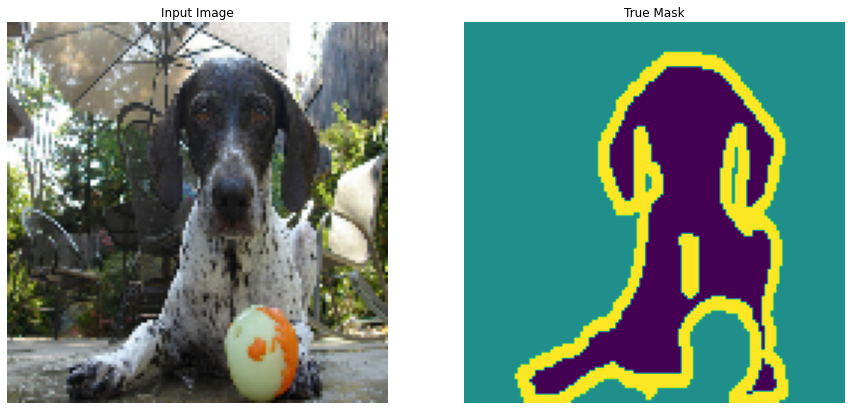

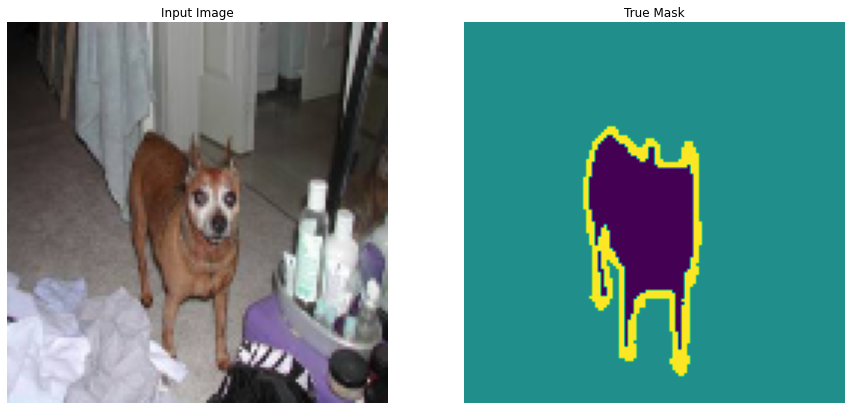

2023-05-31 22:57:53.461502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:
import numpy as np

In [15]:
sample_image, sample_mask = next(iter(train_batches))
mask = tf.reshape(sample_mask, [2, -1, 1])
zero_mask = tf.zeros_like(mask)
mask_ext = tf.concat([mask, zero_mask, zero_mask], axis = 2)
img = tf.reshape(sample_image, [2, -1, 3])

dim_horizontal = np.linspace(0, 1, 128)
dim_vertical = np.linspace(0, 1, 128)
x, x2 = np.meshgrid(dim_horizontal, dim_vertical)
x = np.concatenate([x[:, :, np.newaxis], x2[:, :, np.newaxis]], axis=2)
x = np.concatenate([x.reshape(1, -1, 2), x.reshape(1, -1, 2)], axis=1)
x = np.repeat(x, 2, axis=0)

y = np.concatenate([img, mask_ext], axis=1)

Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-05-31 22:58:00.657019: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
OUTPUT_CLASSES = 3

In [17]:
m = model_init.model_init('leak', 9, 'forecasting/bc/', multiply = 2, bc=True, subsample = True, y_target_dim = 3)
m.load_model()

(<tensorflow.python.training.tracking.util.Checkpoint at 0x28453fc70>,
 <tensorflow.python.training.checkpoint_management.CheckpointManager at 0x2859f1ac0>)

In [18]:
from model import losses

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [20]:
from model import atp_pipeline

In [24]:
model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.05, permutation_repeats=0,
                    bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1, MHAX_leakage=True, multiply=2, bc=True, subsample=True, y_target_dim=3) 

In [25]:
with tf.device('/cpu:0'):

    for i in range(100):
        n_C = np.array([16000, 16000])
        n_T = np.array([384, 384])
        n_C_s = np.array([128, 64])
        n_T_s = np.array([0, 64])
        sample_image, sample_mask = next(iter(train_batches))
        mask = tf.reshape(sample_mask, [2, -1, 1])
        zero_mask = tf.zeros_like(mask)
        mask_ext = tf.concat([mask, zero_mask, zero_mask], axis = 2)
        img = tf.reshape(sample_image, [2, -1, 3])

        dim_horizontal = np.linspace(0, 1, 128)
        dim_vertical = np.linspace(0, 1, 128)
        x, x2 = np.meshgrid(dim_horizontal, dim_vertical)
        x = np.concatenate([x[:, :, np.newaxis], x2[:, :, np.newaxis]], axis=2)
        x = np.concatenate([x.reshape(1, -1, 2), x.reshape(1, -1, 2)], axis=1)
        x = np.repeat(x, 2, axis=0)

        y = np.concatenate([img, mask_ext], axis=1)
        with tf.GradientTape(persistent=True) as tape:
            μ , sig, y1 = model([x, y, n_C, n_T, True, n_C_s, n_T_s])
            likpp, mse = losses.categorical_ce(y1, μ)
        gradients = tape.gradient(likpp, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # for ix,  var in enumerate(m.model.trainable_variables):
        #     if ix == 0:
        #         print(test_var.numpy()  == var.numpy())
        # tf.print(m.model.trainable_variables)

Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-06-01 00:19:03.946238: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor(128, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
y_diff.shape (2, 128, 6)
x_diff.shape (2, 128, 4)
d.shape (2, 128, 8)
x_n.shape (2, 128, 4)
y_n.shape (2, 128, 6)
tf.Tensor(64, shape=(), dtype=int64) tf.Tensor(64, shape=(), dtype=int64)
y_diff.shape (2, 128, 6)
x_diff.shape (2, 128, 4)
d.shape (2, 128, 8)
x_n.shape (2, 128, 4)
y_n.shape (2, 128, 6)
n_C_before: tf.Tensor([128  64], shape=(2,), dtype=int64)
n_T_before: tf.Tensor([ 0 64], shape=(2,), dtype=int64)


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-06-01 00:19:04.740296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-01 00:19:04.770289: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: Index out of range using input dim 0; input has only 0 dims


tf.Tensor(128, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)


InvalidArgumentError: Exception encountered when calling layer "atp_pipeline_2" (type atp_pipeline).

Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: atp_pipeline_2/strided_slice/

Call arguments received:
  • inputs=['tf.Tensor(shape=(2, 32768, 2), dtype=float32)', 'tf.Tensor(shape=(2, 32768, 3), dtype=float32)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(), dtype=bool)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(2,), dtype=int64)']

In [29]:
n_C = [16000, 16000]
n_T = [384, 384]
n_C_s = [128, 64]
n_T_s = [0, 64]

In [30]:
# mu , sig, y1 = m.model([x, y, n_C, n_T, True, n_C_s, n_T_s])

In [23]:
tr_step = atp_graph.build_graph()

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [25]:
n_C = np.array([16000, 16000])
n_T = np.array([384, 384])
n_C_s = np.array([128, 64])
n_T_s = np.array([0, 64])
μ, _, likpp, _ = tr_step(m.model, opt, x, y, n_C, n_T, multiple =2, training = True, n_C_s = n_C_s, n_T_s = n_T_s, img_seg = True)

Tensor("atp_pipeline/strided_slice_26:0", shape=(), dtype=int64) Tensor("atp_pipeline/strided_slice_27:0", shape=(), dtype=int64)


TypeError: in user code:

    File "/Users/omernivron/Documents/ATP/model/atp_graph.py", line 12, in train_step  *
        μ, log_σ, y1 = atp_model([x, y, n_C, n_T, training, n_C_s, n_T_s])
    File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "atp_pipeline" (type atp_pipeline).
    
    in user code:
    
        File "/Users/omernivron/Documents/ATP/model/atp_pipeline.py", line 146, in call  *
            inputs_for_processing, y, y_n, _, _ = self.inputs_for_multi_ts(x, y, n_C, n_T, n_C_s, n_T_s)
        File "/Users/omernivron/Documents/ATP/model/atp_pipeline.py", line 74, in inputs_for_multi_ts  *
            y_diff, x_diff, d, x_n, y_n = self._DE([y_temp, x_temp, n_C_s[i], n_T_s[i], True]) #  (32, 30, 1),  (32, 30, 1), (32, 30, 2), (32, 30, 1), (32, 30, 1)
        File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "de" (type DE).
        
        in user code:
        
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 136, in call  *
                y_diff,  x_diff,  d,  x_n,  y_n = self.derivative_function_2d([y,  x,  n_C,  n_T])
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 360, in derivative_function_2d  *
                x_mask = tf.linalg.band_part(tf.ones((target_m, context_n + target_m), tf.bool), -1, context_n)
        
            TypeError: Input 'num_upper' of 'MatrixBandPart' Op has type int64 that does not match type int32 of argument 'num_lower'.
        
        
        Call arguments received:
          • inputs=['tf.Tensor(shape=(2, None, 3), dtype=float32)', 'tf.Tensor(shape=(2, None, 2), dtype=float32)', 'tf.Tensor(shape=(), dtype=int64)', 'tf.Tensor(shape=(), dtype=int64)', 'tf.Tensor(shape=(), dtype=bool)']
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(2, 32768, 2), dtype=float32)', 'tf.Tensor(shape=(2, 32768, 3), dtype=float32)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(), dtype=bool)', 'tf.Tensor(shape=(2,), dtype=int64)', 'tf.Tensor(shape=(2,), dtype=int64)']


In [28]:
 y_true = [1, 2]
 y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
 # Using 'auto'/'sum_over_batch_size' reduction type.
 scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
 scce(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.05129344, 2.3025851 ], dtype=float32)>